# qGANS定价 Option Pricing with qGANs

## 简介

#### 在本笔记本中，我们讨论量子机器学习算法，即量子生成对抗网络(qGAN)，如何促进欧洲看涨期权的定价。更具体地说，qGAN可以训练成量子电路模拟欧洲看涨期权基础资产的现货价格。由此得到的模型可以集成到基于量子振幅估计的算法中，以评估预期的收益-参见欧洲看涨期权定价。关于通过训练qGAN学习和加载随机分布的更多细节，请参阅用于学习和加载随机分布的量子生成对抗网络。Zoufal, Lucchi, weerner, 2019。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer, QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, NormalDistribution
from qiskit.quantum_info import Statevector

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.finance.applications import EuropeanCallExpectedValue

D:\Anaconda\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
D:\Anaconda\lib\site-packages\qiskit\finance\__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')


##  不确定性模型 Uncertainty Model¶
#### Black-Scholes模型假设欧洲看涨期权在到期时$S_T$的现货价格是对数正态分布的。因此，我们可以对来自对数正态分布的样本训练qGAN，并将结果作为选项背后的不确定性模型。接下来，我们构建一个量子电路，加载不确定性模型。电路输出读数

<center>$ {∣g_\theta⟩} = \sum_{j=0}^{2^n−1}\sqrt{p_θ^j}{∣j⟩}$</center>
#### 其中，对于$j∈{0，…，2n−1}$，概率 $p_θ^j$ 表示目标分布模型。

In [2]:
# 设置上、下数据值
bounds = np.array([0.,7.])
# 不确定性模型中使用的量子位元的集合数
num_qubits = 3

#加载训练过的电路参数
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

# 设置发电机电路的初始状态
init_dist = NormalDistribution(num_qubits, mu=1., sigma=1., bounds=bounds)

# 构造变分形式
var_form = TwoLocal(num_qubits, 'ry', 'cz', entanglement='circular', reps=1)

# 保留一个参数列表，以便我们可以将它们与数值列表关联起来
# (否则我们需要一个字典)
theta = var_form.ordered_parameters

# 组成生成电路，这是加载不确定性模型的电路
g_circuit = init_dist.compose(var_form)

<ipython-input-2-9d10bcde929b>:10: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.
  init_dist = NormalDistribution(num_qubits, mu=1., sigma=1., bounds=bounds)


## 评估预期收益 Evaluate Expected Payoff

#### 现在，训练的不确定性模型可以用量子振幅估计来评估期权收益函数的期望值。

In [3]:
#设置执行价格(应该在不确定性的低值和高值范围内)
strike_price = 2

#设置成本函数的近似缩放
c_approx = 0.25

#为成本函数构造电路
european_call_objective = EuropeanCallExpectedValue(
    num_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=bounds
)

## 绘制概率分布

##### 接下来，我们绘制训练后的概率分布图，为了便于比较，我们也绘制目标概率分布图。

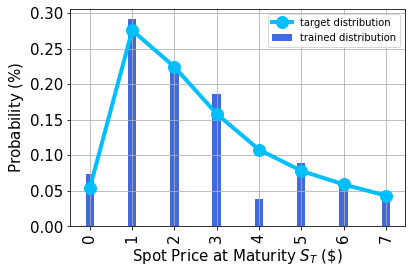

In [4]:
# 评估训练过的概率分布
values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2 ** num_qubits - 1) for x in range(2**num_qubits)]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# 从目标概率分布中抽取样本
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# 画出分布
plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

## 评估预期收益

#### 现在，训练的不确定性模型可以用量子振幅估计的方法解析求解期权收益函数的期望值。

Analytically calculated expected payoff w.r.t. the target distribution:  1.0598
Analytically calculated expected payoff w.r.t. the trained distribution: 0.9805


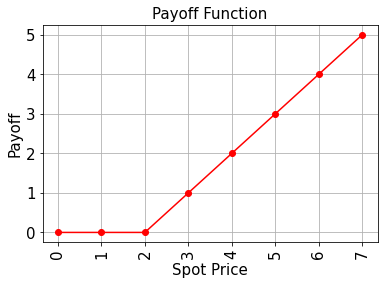

In [5]:
#评估不同发行版本的收益
payoff = np.array([0,0,0,1,2,3,4,5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

#绘制精确的收益函数(在训练的不确定性模型的网格上进行评估)
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
#为QAE构造一个操作符
european_call = european_call_objective.compose(uncertainty_model, front=True)

In [7]:
#设置目标精度和置信水平
epsilon = 0.01
alpha = 0.05

# 构造振幅估计
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_call,
                                  objective_qubits=[num_qubits],
                                  post_processing=european_call_objective.post_processing)

D:\Anaconda\lib\site-packages\qiskit\aqua\algorithms\amplitude_estimators\ae_algorithm.py:91: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_estimators is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_estimators (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.amplitude_estimators',


In [8]:
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=1000)

D:\Anaconda\lib\site-packages\qiskit\aqua\quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
D:\Anaconda\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


In [9]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:        \t%.4f' % ep_trained)
print('Estimated value:    \t%.4f' % (result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.9805
Estimated value:    	1.0031
Confidence interval:	[0.9622, 1.0440]
